# Data curation

**Initial instructions:**<br>

This tutorial was designed to demonstrate how to use the ULaMDyn package as a python API for collecting data from the outputs of NAMD trajectories generated by the Newton-X program. The **ULaMDyn API** provides a flexible framework to manipulate the information collected by the program and structured into pandas DataFrame objects either via interactive Jupyter environment or by developing customized scripts for specific purposes.

* You should be inside of the TRAJECTORIES directory in your Newton-X calculation.  
* Ulamdyn will look for the file control.dyn, which should be inside of TRAJECTORIES.  
* Import the modules you are going to use.

In [1]:
import ulamdyn as umd
import pandas as pd
import numpy as np

## **GetProperties:**  


Read and process all properties available in the outputs of Newton-X MD trajectories (RESULTS directory). In this class, there are several methods implemented to extract specific information: energies(), oscillator_strength(), populations() and save_csv.

Energy quantities processed by this class are transformed from u.a. to eV. For the other properties, the original units used in NX are kept.

In [2]:
# Instanciate the class:
properties = umd.GetProperties()

### 1. energies(): 

Read and process the energy information from the en.dat (classical NX) or .h5 (new NX) file and return a processed pandas dataframe with the information of all trajectories stacked.

In [3]:
df_en = properties.energies()
df_en.head()

Reading energies from TRAJ1...
Reading energies from TRAJ2...
Reading energies from TRAJ3...
Reading energies from TRAJ4...
Reading energies from TRAJ5...

-----------------------------------------------------
The properties dataset is empty.
Updating class variable with the current loaded data.
-----------------------------------------------------



TRAJ  time  State  Total_Energy  Hops_S12           S1  Hops_S21      DE21
0     1   0.0      2  -6271.713990         0 -6276.740507         0  3.852182
1     1   0.1      2  -6271.714018         0 -6276.777841         0  3.839637
2     1   0.2      2  -6271.714045         0 -6276.812753         0  3.825025
3     1   0.3      2  -6271.714072         0 -6276.844754         0  3.808371
4     1   0.4      2  -6271.714099         0 -6276.873408         0  3.789650

This dataframe shows the line number, the identifier of NX trajectory (TRAJ), the current state of the trajectory (State), the total energy, the hopings between the states (Hops_S12 and Hops_S21), the energy difference between the accessible states (DE21) and the absolute energy of the ground state.

In [4]:
df_en.columns

Index(['TRAJ', 'time', 'State', 'Total_Energy', 'Hops_S12', 'S1', 'Hops_S21',
       'DE21'],
      dtype='object')

Using the pandas functions, one can easily obtain a full description of the dataset generated by ulamdyn.

In [5]:
df_en.describe()

TRAJ         time        State  Total_Energy     Hops_S12  \
count  2984.000000  2984.000000  2984.000000   2984.000000  2984.000000   
mean      3.000000    29.795912     1.222185  -6271.688662     0.000670   
std       1.419419    17.241088     0.415785      0.150424     0.025885   
min       1.000000     0.000000     1.000000  -6271.831571     0.000000   
25%       2.000000    14.900000     1.000000  -6271.820060     0.000000   
50%       3.000000    29.800000     1.000000  -6271.714317     0.000000   
75%       4.000000    44.700000     1.000000  -6271.675133     0.000000   
max       5.000000    60.000000     2.000000  -6271.412352     1.000000   

                S1     Hops_S21         DE21  
count  2984.000000  2984.000000  2984.000000  
mean  -6274.989408     0.002346     3.280622  
std       0.935564     0.048385     1.823839  
min   -6277.687709     0.000000     0.020926  
25%   -6275.582451     0.000000     1.769013  
50%   -6274.911697     0.000000     3.242157  
75%   -6274.352965     0.000000     4.641496  
max   -6272.713601     1.000000     7.197878

#### Counting the number of entries.

From this initial dataframe, it is already possible to capture some characteristics of the dataframe. For example, with *count* it is possible to check how many entries we have in the dataframe and with *nunique* we can obtain the number of unique values, that applied to the trajectories column, return the number of trajectories available in the directory.

In [6]:
df_en.count()

TRAJ            2984
time            2984
State           2984
Total_Energy    2984
Hops_S12        2984
S1              2984
Hops_S21        2984
DE21            2984
dtype: int64

In [7]:
df_en['TRAJ'].nunique()

5

#### Getting features of MD trajectories.

It is also possible to group the information available in the dataframe in a more convenient way. For example, by using the *groupby* function of pandas one can easily obtain the maximum time of the dynamics for each one of the trajectories read by the program.

In [8]:
df_en.groupby(['TRAJ']).max()

time  State  Total_Energy  Hops_S12           S1  Hops_S21      DE21
TRAJ                                                                      
1     60.0      2  -6271.713854         0 -6273.107350         1  6.510790
2     60.0      2  -6271.674398         0 -6273.463466         1  6.695882
3     57.9      2  -6271.809829         1 -6273.447465         1  6.806442
4     60.0      2  -6271.828714         1 -6273.092656         1  6.676670
5     60.0      2  -6271.412352         0 -6272.713601         1  7.197878

#### Selecting properties of hopping points

The command shown below is an example of how to filter the energy dataframe dataframe to display only the rows in which there is a hopping between states 1 and 2.

In [9]:
hoppings_S12 = df_en[df_en['Hops_S12'] == 1 ]
hoppings_S12

TRAJ  time  State  Total_Energy  Hops_S12           S1  Hops_S21  \
1281     3   7.9      1  -6271.823435         1 -6274.287182         0   
1921     4  13.9      1  -6271.830863         1 -6274.562262         0   

          DE21  
1281  0.028545  
1921  1.091885

From the filtered dataset shown above, one can easily identify relevant information related to the hopping time such as the energy gap between S0 and S1, given by the column "DE21".

#### Visualizing time evolution of the potential energy

- Energy of state 1:

To obtain the absolute value of root 2, i. e. S1 state, we need to add the DE21 gap (in eV) to the root1 potential energy (in atomic unities), i. e. S0. And then, add it to the dataframe as column. 

In [10]:
df_en['Root2'] = df_en['Total_Energy'] + df_en['DE21']
df_en

TRAJ  time  State  Total_Energy  Hops_S12           S1  Hops_S21  \
0        1   0.0      2  -6271.713990         0 -6276.740507         0   
1        1   0.1      2  -6271.714018         0 -6276.777841         0   
2        1   0.2      2  -6271.714045         0 -6276.812753         0   
3        1   0.3      2  -6271.714072         0 -6276.844754         0   
4        1   0.4      2  -6271.714099         0 -6276.873408         0   
...    ...   ...    ...           ...       ...          ...       ...   
2979     5  59.6      1  -6271.412760         0 -6274.238936         0   
2980     5  59.7      1  -6271.412760         0 -6274.225956         0   
2981     5  59.8      1  -6271.412760         0 -6274.214527         0   
2982     5  59.9      1  -6271.412733         0 -6274.204813         0   
2983     5  60.0      1  -6271.412733         0 -6274.196922         0   

          DE21        Root2  
0     3.852182 -6267.861809  
1     3.839637 -6267.874380  
2     3.825025 -6267.889020  
3     3.808371 -6267.905701  
4     3.789650 -6267.924449  
...        ...          ...  
2979  5.447232 -6265.965528  
2980  5.497873 -6265.914888  
2981  5.548187 -6265.864574  
2982  5.598147 -6265.814586  
2983  5.647644 -6265.765089  

[2984 rows x 9 columns]

We can then later obtain filter the dataframe to obtain root 2 energy from a specific trajectory and use it to plot the potential energy surfaces of the relevant states. 

- Energy of the current state:

In [11]:
df_en['only_root2'] = df_en[df_en['State'] == 2]['Root2']
df_en['only_root1'] = df_en[df_en['State'] == 1]['S1']
df_en = df_en.fillna(0.0)
df_en['Current'] = df_en['only_root2'] + df_en['only_root1']
df_en = df_en.drop(columns='only_root2').drop(columns='only_root1')
df_en

TRAJ  time  State  Total_Energy  Hops_S12           S1  Hops_S21  \
0        1   0.0      2  -6271.713990         0 -6276.740507         0   
1        1   0.1      2  -6271.714018         0 -6276.777841         0   
2        1   0.2      2  -6271.714045         0 -6276.812753         0   
3        1   0.3      2  -6271.714072         0 -6276.844754         0   
4        1   0.4      2  -6271.714099         0 -6276.873408         0   
...    ...   ...    ...           ...       ...          ...       ...   
2979     5  59.6      1  -6271.412760         0 -6274.238936         0   
2980     5  59.7      1  -6271.412760         0 -6274.225956         0   
2981     5  59.8      1  -6271.412760         0 -6274.214527         0   
2982     5  59.9      1  -6271.412733         0 -6274.204813         0   
2983     5  60.0      1  -6271.412733         0 -6274.196922         0   

          DE21        Root2      Current  
0     3.852182 -6267.861809 -6267.861809  
1     3.839637 -6267.874380 -6267.874380  
2     3.825025 -6267.889020 -6267.889020  
3     3.808371 -6267.905701 -6267.905701  
4     3.789650 -6267.924449 -6267.924449  
...        ...          ...          ...  
2979  5.447232 -6265.965528 -6274.238936  
2980  5.497873 -6265.914888 -6274.225956  
2981  5.548187 -6265.864574 -6274.214527  
2982  5.598147 -6265.814586 -6274.204813  
2983  5.647644 -6265.765089 -6274.196922  

[2984 rows x 10 columns]

**Plotting the results**

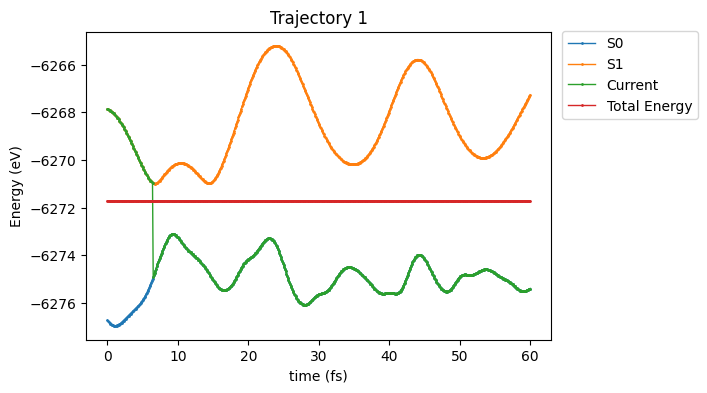

In [12]:
# First some code lines to set up the plot.
import matplotlib.pyplot as plt
fig , ax = plt.subplots(figsize=(6,4))

## 1. Subplot 1: Mean Population
# syntax: plt.subplot(number_lines, number_columns, selected_plot)
plt.subplot(1, 1, 1)

TRAJ_ID = 1

# syntax: plt.plot(x-axis, y-axis, series_label, type_marker, ...)
plt.plot(df_en[df_en['TRAJ'] == TRAJ_ID ]['time'], df_en[df_en['TRAJ'] == TRAJ_ID ]['S1'],           label='S0',           marker='o', linewidth=1, markersize=1)
plt.plot(df_en[df_en['TRAJ'] == TRAJ_ID ]['time'], df_en[df_en['TRAJ'] == TRAJ_ID ]['Root2'],        label='S1',           marker='o', linewidth=1, markersize=1)
plt.plot(df_en[df_en['TRAJ'] == TRAJ_ID ]['time'], df_en[df_en['TRAJ'] == TRAJ_ID ]['Current'],      label='Current',      marker='o', linewidth=1, markersize=1)
plt.plot(df_en[df_en['TRAJ'] == TRAJ_ID ]['time'], df_en[df_en['TRAJ'] == TRAJ_ID ]['Total_Energy'], label='Total Energy', marker='o', linewidth=1, markersize=1)

# x- and y-axis labels
plt.ylabel('Energy (eV)', fontsize=10)
plt.xlabel('time (fs)'  , fontsize=10)

# # Legend placement and style
plt.legend(loc='center right', bbox_to_anchor=(1.33, 0.86), frameon=None, ncol=1)
plt.title("Trajectory "+str(TRAJ_ID))
plt.show()

### 2. oscillator_strength(): 


This is a method of the GetProperties class that can be used to collect the oscillator strength computed by an external QM program during the dynamics simulation. After calling this method, the oscillator strength data collected from all trajectories will be merged with the existing properties dataset.

**Note:** The availability of the oscillator strength data depends on the QM program / method used to compute the electronic structure of the system. If available, ULaMDyn will collect this information from the RESULTS/properties file (classical NX) or from the .h5 file (new NX) for each MD trajectory.</div>

In [13]:
properties.oscillator_strength()

Reading oscillator strength from TRAJ1...
Reading oscillator strength from TRAJ2...
Reading oscillator strength from TRAJ3...
Reading oscillator strength from TRAJ4...
Reading oscillator strength from TRAJ5...


TRAJ  time  State  Total_Energy  Hops_S12           S1  Hops_S21  \
0        1   0.0      2  -6271.713990         0 -6276.740507         0   
1        1   0.1      2  -6271.714018         0 -6276.777841         0   
2        1   0.2      2  -6271.714045         0 -6276.812753         0   
3        1   0.3      2  -6271.714072         0 -6276.844754         0   
4        1   0.4      2  -6271.714099         0 -6276.873408         0   
...    ...   ...    ...           ...       ...          ...       ...   
2979     5  59.6      1  -6271.412760         0 -6274.238936         0   
2980     5  59.7      1  -6271.412760         0 -6274.225956         0   
2981     5  59.8      1  -6271.412760         0 -6274.214527         0   
2982     5  59.9      1  -6271.412733         0 -6274.204813         0   
2983     5  60.0      1  -6271.412733         0 -6274.196922         0   

          DE21        Root2   only_root2   only_root1      f_21  
0     3.852182 -6267.861809 -6267.861809          NaN -0.004430  
1     3.839637 -6267.874380 -6267.874380          NaN -0.004396  
2     3.825025 -6267.889020 -6267.889020          NaN -0.004357  
3     3.808371 -6267.905701 -6267.905701          NaN -0.004313  
4     3.789650 -6267.924449 -6267.924449          NaN -0.004266  
...        ...          ...          ...          ...       ...  
2979  5.447232 -6265.965528          NaN -6274.238936 -0.006061  
2980  5.497873 -6265.914888          NaN -6274.225956 -0.006146  
2981  5.548187 -6265.864574          NaN -6274.214527 -0.006231  
2982  5.598147 -6265.814586          NaN -6274.204813 -0.006318  
2983  5.647644 -6265.765089          NaN -6274.196922 -0.006405  

[2984 rows x 12 columns]

### 3. populations(): 


The population is a key quantity in nonadiabatic molecular dynamics often used to estimate the lifetime of an excited state. ULaMDyn provides a function to compute the population of each excited state from the coefficients of the wave function available in the NX output. The populations() function implemented in the GetProperties class can be called to add the information of the state's population to an existing properties dataset, in a similar way to the other functions discussed previously, as you can see in the example below:

In [14]:
df_pop = properties.populations()

Reading populations from TRAJ1...
Reading populations from TRAJ2...
Reading populations from TRAJ3...
Reading populations from TRAJ4...
Reading populations from TRAJ5...


In [15]:
df_pop

TRAJ  time  State  Total_Energy  Hops_S12           S1  Hops_S21  \
0        1   0.0      2  -6271.713990         0 -6276.740507         0   
1        1   0.1      2  -6271.714018         0 -6276.777841         0   
2        1   0.2      2  -6271.714045         0 -6276.812753         0   
3        1   0.3      2  -6271.714072         0 -6276.844754         0   
4        1   0.4      2  -6271.714099         0 -6276.873408         0   
...    ...   ...    ...           ...       ...          ...       ...   
2979     5  59.6      1  -6271.412760         0 -6274.238936         0   
2980     5  59.7      1  -6271.412760         0 -6274.225956         0   
2981     5  59.8      1  -6271.412760         0 -6274.214527         0   
2982     5  59.9      1  -6271.412733         0 -6274.204813         0   
2983     5  60.0      1  -6271.412733         0 -6274.196922         0   

          DE21        Root2   only_root2   only_root1      f_21      Pop1  \
0     3.852182 -6267.861809 -6267.861809          NaN -0.004430  0.000000   
1     3.839637 -6267.874380 -6267.874380          NaN -0.004396  0.000001   
2     3.825025 -6267.889020 -6267.889020          NaN -0.004357  0.000004   
3     3.808371 -6267.905701 -6267.905701          NaN -0.004313  0.000006   
4     3.789650 -6267.924449 -6267.924449          NaN -0.004266  0.000008   
...        ...          ...          ...          ...       ...       ...   
2979  5.447232 -6265.965528          NaN -6274.238936 -0.006061  1.000000   
2980  5.497873 -6265.914888          NaN -6274.225956 -0.006146  1.000000   
2981  5.548187 -6265.864574          NaN -6274.214527 -0.006231  1.000000   
2982  5.598147 -6265.814586          NaN -6274.204813 -0.006318  1.000000   
2983  5.647644 -6265.765089          NaN -6274.196922 -0.006405  1.000000   

              Pop2  
0     1.000000e+00  
1     9.999989e-01  
2     9.999964e-01  
3     9.999936e-01  
4     9.999916e-01  
...            ...  
2979  3.998308e-07  
2980  3.824953e-07  
2981  3.651934e-07  
2982  3.479378e-07  
2983  3.307478e-07  

[2984 rows x 14 columns]

Since the properties.energies() function has been already called, the properties.populations() method will append two extra columns corresponding to the populations of calculated for states S1 and S2 to the former dataframe.  

The information in the resulting dataframe can be easily plotted using the seaborn or matplotlib libraries. In the example, the S0 and S1 populations are plotted over time for one specific trajectory using matplotlib.

In [16]:
# Selects the data associated to TRAJ1. 
df_TRAJ1 = df_pop[df_pop['TRAJ'] == 1 ] 

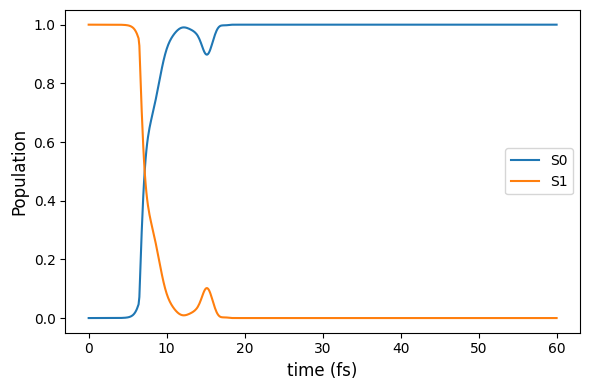

In [17]:
# First, some code lines to set up the plot.
import matplotlib.pyplot as plt
fig , ax = plt.subplots(figsize=(6,4))

# Then, giving labels to the axis...
ax.set_ylabel('Population', fontsize=12)
ax.set_xlabel('time (fs)'      , fontsize=12)

# ... and informing the what should be plotted. x-axis is time and y-axis is the respective populations.
plt.plot(df_TRAJ1['time'], df_TRAJ1['Pop1'], label='S0')
plt.plot(df_TRAJ1['time'], df_TRAJ1['Pop2'], label='S1')

# And, finally, setting up the data labels. 
ax.legend(loc='best', frameon=None)
plt.tight_layout()
plt.show()

### 4. nac_norm()

Calculate the norm of the nonadiabatic coupling matrices for each pair of states. After running this function, the properties dataset sored in the class variable *GetProperties.dataset* will be updated with the computed NACs norm data. Before running this function, let's first take a look at the current state of the properties dataset.

In [18]:
properties.dataset

TRAJ  time  State  Total_Energy  Hops_S12           S1  Hops_S21  \
0        1   0.0      2  -6271.713990         0 -6276.740507         0   
1        1   0.1      2  -6271.714018         0 -6276.777841         0   
2        1   0.2      2  -6271.714045         0 -6276.812753         0   
3        1   0.3      2  -6271.714072         0 -6276.844754         0   
4        1   0.4      2  -6271.714099         0 -6276.873408         0   
...    ...   ...    ...           ...       ...          ...       ...   
2979     5  59.6      1  -6271.412760         0 -6274.238936         0   
2980     5  59.7      1  -6271.412760         0 -6274.225956         0   
2981     5  59.8      1  -6271.412760         0 -6274.214527         0   
2982     5  59.9      1  -6271.412733         0 -6274.204813         0   
2983     5  60.0      1  -6271.412733         0 -6274.196922         0   

          DE21        Root2   only_root2   only_root1      f_21      Pop1  \
0     3.852182 -6267.861809 -6267.861809          NaN -0.004430  0.000000   
1     3.839637 -6267.874380 -6267.874380          NaN -0.004396  0.000001   
2     3.825025 -6267.889020 -6267.889020          NaN -0.004357  0.000004   
3     3.808371 -6267.905701 -6267.905701          NaN -0.004313  0.000006   
4     3.789650 -6267.924449 -6267.924449          NaN -0.004266  0.000008   
...        ...          ...          ...          ...       ...       ...   
2979  5.447232 -6265.965528          NaN -6274.238936 -0.006061  1.000000   
2980  5.497873 -6265.914888          NaN -6274.225956 -0.006146  1.000000   
2981  5.548187 -6265.864574          NaN -6274.214527 -0.006231  1.000000   
2982  5.598147 -6265.814586          NaN -6274.204813 -0.006318  1.000000   
2983  5.647644 -6265.765089          NaN -6274.196922 -0.006405  1.000000   

              Pop2  
0     1.000000e+00  
1     9.999989e-01  
2     9.999964e-01  
3     9.999936e-01  
4     9.999916e-01  
...            ...  
2979  3.998308e-07  
2980  3.824953e-07  
2981  3.651934e-07  
2982  3.479378e-07  
2983  3.307478e-07  

[2984 rows x 14 columns]

In [19]:
df_with_nacs = properties.nac_norm()

Reading nonadiabatic couplings from TRAJ1...
Reading nonadiabatic couplings from TRAJ2...
Reading nonadiabatic couplings from TRAJ3...
Reading nonadiabatic couplings from TRAJ4...
Reading nonadiabatic couplings from TRAJ5...


In [20]:
# Updated properties dataset
properties.dataset

TRAJ  time  State  Total_Energy  Hops_S12           S1  Hops_S21  \
0        1   0.0      2  -6271.713990         0 -6276.740507         0   
1        1   0.1      2  -6271.714018         0 -6276.777841         0   
2        1   0.2      2  -6271.714045         0 -6276.812753         0   
3        1   0.3      2  -6271.714072         0 -6276.844754         0   
4        1   0.4      2  -6271.714099         0 -6276.873408         0   
...    ...   ...    ...           ...       ...          ...       ...   
2979     5  59.6      1  -6271.412760         0 -6274.238936         0   
2980     5  59.7      1  -6271.412760         0 -6274.225956         0   
2981     5  59.8      1  -6271.412760         0 -6274.214527         0   
2982     5  59.9      1  -6271.412733         0 -6274.204813         0   
2983     5  60.0      1  -6271.412733         0 -6274.196922         0   

          DE21        Root2   only_root2   only_root1      f_21      Pop1  \
0     3.852182 -6267.861809 -6267.861809          NaN -0.004430  0.000000   
1     3.839637 -6267.874380 -6267.874380          NaN -0.004396  0.000001   
2     3.825025 -6267.889020 -6267.889020          NaN -0.004357  0.000004   
3     3.808371 -6267.905701 -6267.905701          NaN -0.004313  0.000006   
4     3.789650 -6267.924449 -6267.924449          NaN -0.004266  0.000008   
...        ...          ...          ...          ...       ...       ...   
2979  5.447232 -6265.965528          NaN -6274.238936 -0.006061  1.000000   
2980  5.497873 -6265.914888          NaN -6274.225956 -0.006146  1.000000   
2981  5.548187 -6265.864574          NaN -6274.214527 -0.006231  1.000000   
2982  5.598147 -6265.814586          NaN -6274.204813 -0.006318  1.000000   
2983  5.647644 -6265.765089          NaN -6274.196922 -0.006405  1.000000   

              Pop2  NAC_S2S1  
0     1.000000e+00  0.715162  
1     9.999989e-01  0.714953  
2     9.999964e-01  0.715183  
3     9.999936e-01  0.715848  
4     9.999916e-01  0.716958  
...            ...       ...  
2979  3.998308e-07  0.368913  
2980  3.824953e-07  0.363998  
2981  3.651934e-07  0.359262  
2982  3.479378e-07  0.354702  
2983  3.307478e-07  0.350316  

[2984 rows x 15 columns]